<a href="https://colab.research.google.com/github/james-monahan/Code-school-notebooks/blob/main/Week-8-pandas-sql/yuka_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This is still a work in progress, but complete enough for submission  

#Il s'agit d'un travail encore en cours, mais suffisamment complet pour être soumis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

#Summary

#Data difficulties  
>Calorie scales mixed kj/jc  
>Counts provided for ingred, palm were innacurate  
>Discrepencies between French UK ratings  
>Values less than zero  
>example Single company, same prod, diff results

#Clustering  
>Kmeans appears more accurate to wider ratings  

#Tensorflow results
>90% accuracy, surprising given energy discrepancies

#Conclusion  
>Until energy is correct, analysis is difficult as calorie is very important to examining food  

#Client
>Data needs further processing  
>Model provided that predicts to NutriScore  



#Load and Transform 

In [ ]:
url = 'https://drive.google.com/open?id=1L4tDDnZWwPDjeRKlleoYHgic2_xNhZ8i'
file_id = '1L4tDDnZWwPDjeRKlleoYHgic2_xNhZ8i'
downloaded = drive.CreateFile({'id': file_id}) 
print(downloaded['title']) 
downloaded.GetContentFile('fr.openfoodfacts.org.products.csv')  
df_ = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t') 

threshold = int(df_.shape[0]*.6) #greater than 60% of values
exceptions = ["pnns_groups_1", "pnns_groups_2", "nutrition-score-fr_100g", "nutrition-score-uk_100g"]
to_drop = ["creator","created_t","created_datetime","last_modified_t","brands_tags",
"countries","countries_tags","additives_tags","states","states_tags"]
df_.drop(to_drop, axis=1, inplace=True)
all_cols =  df_.columns
cols_for_dropping = list(set(all_cols)-set(exceptions))
df_ = pd.concat([df_.drop(exceptions, axis=1).dropna(axis=1, thresh=threshold, inplace=False), df_[exceptions]], axis=1)

fr.openfoodfacts.org.products.csv


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#I am working with the entire dataset, not just French
#I forgot to do this at first, but then noticed the data returned is much different
#I had already invested a bit of time, so I continue with full dataset


df = df_.copy()

#France only
#mask = (df["countries_fr"].str.contains('France', na=False))
#df = df[mask].reset_index(drop=True)

In [ ]:
df.sample(3)

,code,url,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,pnns_groups_1,pnns_groups_2,nutrition-score-fr_100g,nutrition-score-uk_100g
249539,3700036902527,http://world-fr.openfoodfacts.org/produit/3700...,2017-01-25T07:55:25Z,Goûters fourrés,Naturalia,France,NaN,"46,3 g",NaN,NaN,NaN,NaN,d,"A compléter,Informations nutritionnelles compl...",2014.0,19.0,5.4,67.0,33.0,3.2,8.6,0.5700,0.224409,unknown,unknown,16.0,16.0
319234,9300675001113,http://world-fr.openfoodfacts.org/produit/9300...,2017-03-14T17:54:15Z,Coca Cola,Coca Cola,Australie,"Carbonated Purified Water, Cane Sugar, Color (...",250 ml,0.0,[ carbonated-purified-water -> en:carbonated-...,0.0,0.0,e,"A compléter,Informations nutritionnelles compl...",180.0,0.0,0.0,10.6,10.6,NaN,0.0,0.0254,0.010000,Beverages,Sweetened beverages,14.0,2.0
227845,3350033199538,http://world-fr.openfoodfacts.org/produit/3350...,2015-09-19T12:02:32Z,"Le Club Jambon, Œuf, Bacon",Monop' daily,France,Pain de mie au _blé_ malté 42% [farine de _blé...,185g,5.0,[ pain-de-mie-au-ble-malte-42 -> fr:pain-de-m...,0.0,2.0,b,"A vérifier,Complet,Informations nutritionnelle...",910.0,8.9,2.9,22.0,1.8,2.5,11.0,1.2000,0.472441,Composite foods,Sandwich,1.0,1.0


#Data Cleaning
to do:  
list/explain tasks

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 27 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   url                                      320749 non-null  object 
 2   last_modified_datetime                   320772 non-null  object 
 3   product_name                             303010 non-null  object 
 4   brands                                   292360 non-null  object 
 5   countries_fr                             320492 non-null  object 
 6   ingredients_text                         248962 non-null  object 
 7   serving_size                             211331 non-null  object 
 8   additives_n                              248939 non-null  float64
 9   additives                                248905 non-null  object 
 10  ingredients_from_palm_oil_n     

In [ ]:
#extract all text containing gram information
df['regex'] = df['serving_size']
mask = df['serving_size'].isna()==False
idx_grams = df[mask]['serving_size'].str.findall('\d+\s?g').explode().index
df.iloc[idx_grams, df.columns.get_loc('regex')] = df[mask]['serving_size'].str.findall('\d*\.*\d+\s?g').explode().values
#overwrite original col with regex extraction
idx_regex = df[df['regex'].isna() == False].index
df.iloc[idx_regex, df.columns.get_loc('serving_size')] = df.iloc[idx_regex, df.columns.get_loc('regex')]
#seperate values and add to new cols
mask = df['serving_size'].isna()==False
df['serving_size_val'] = df[mask]['serving_size'].apply(lambda x: (x.split()[0:1]))
df['serving_size_type'] = df[mask]['serving_size'].apply(lambda x: (x.split()[1:2]))
df['serving_size_val'] = df['serving_size_val'].explode()
df['serving_size_val'] = df['serving_size_val'].str.replace(",", ".")
df['serving_size_type'] = df['serving_size_type'].explode()

#seperate '...ml' values (no space between)
idx_serving = df[df['serving_size_val'].str.contains('ml', na=False)]['serving_size_val'].str.split('ml').index
df.iloc[idx_serving, df.columns.get_loc('serving_size_val')] = df.iloc[idx_serving, df.columns.get_loc('serving_size_val')].apply(lambda x: (x.split('ml')[0:1])).explode()
df.iloc[idx_serving, df.columns.get_loc('serving_size_type')] = 'ml'

#seperate '...g' values (no space between)
idx_serving = df[df['serving_size_val'].str.contains('g', na=False)]['serving_size_val'].str.split('g').index
df.iloc[idx_serving, df.columns.get_loc('serving_size_val')] = df.iloc[idx_serving, df.columns.get_loc('serving_size_val')].apply(lambda x: (x.split('g')[0:1])).explode()
df.iloc[idx_serving, df.columns.get_loc('serving_size_type')] = 'g'

#numpy coerce all remaining to nan and convert col to numeric
x = df['serving_size_val'].isna().sum()
df['serving_size_val'] = pd.to_numeric(df['serving_size_val'], errors='coerce')
print("lost vals=",df['serving_size_val'].isna().sum()-x)

#final touchup
df['serving_size_type'] = df['serving_size_type'].str.lower()
df['serving_size_type'] = df['serving_size_type'].str.replace(".", "")

print(df[['serving_size', 'serving_size_val', 'serving_size_type', 'regex']].sample(10))
#get rid of extra columns
df = df.drop(['serving_size','regex'], axis=1)

lost vals= 604
       serving_size  serving_size_val serving_size_type  regex
68250          61 g              61.0                 g   61 g
106361        1.3 g               1.3                 g  1.3 g
287611          NaN               NaN               NaN    NaN
154137        128 g             128.0                 g  128 g
25495          30 g              30.0                 g   30 g
238972          NaN               NaN               NaN    NaN
81942         133 g             133.0                 g  133 g
255789          NaN               NaN               NaN    NaN
188136        420 g             420.0                 g  420 g
117687        118 g             118.0                 g  118 g


In [ ]:
#check food measurements
df['serving_size_type'].value_counts().nlargest(5)

g        182343
ml        26755
cl          663
verre       344
l           200
Name: serving_size_type, dtype: int64

In [ ]:
# 'ml', 'cl', 'verre' are predominantly beverage products
# for simplicity and to aid comparison, I will focus on products where serving size is measured in grams
df[df['serving_size_type'] == 'ml'].groupby('pnns_groups_1').count()

,code,url,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,pnns_groups_2,nutrition-score-fr_100g,nutrition-score-uk_100g,serving_size_val,serving_size_type
pnns_groups_1,,,,,,,,,,,,,,,,,,,,,,,,,,,
Beverages,2093,2093,2093,2062,2069,2092,1877,1877,1877,1877,1877,1910,2093,2070,2028,1947,2061,2025,1151,2025,2011,2010,2093,1910,1910,2093,2093
Cereals and potatoes,15,15,15,15,15,15,14,14,14,14,14,13,15,15,15,13,15,15,4,15,15,15,15,13,13,15,15
Composite foods,140,140,140,139,140,140,130,130,130,130,130,78,140,140,139,137,139,137,121,138,137,137,140,78,78,140,140
Fat and sauces,322,322,322,316,320,322,282,282,282,282,282,258,322,278,275,269,269,265,166,271,269,269,322,258,258,322,322
Fish Meat Eggs,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1
Fruits and vegetables,249,249,249,247,248,249,239,239,239,239,239,237,249,249,249,249,249,249,224,249,249,249,249,237,237,249,249
Milk and dairy products,412,412,412,412,410,412,386,386,385,386,386,395,412,410,408,399,408,398,191,407,396,396,412,395,395,412,412
Sugary snacks,4,4,4,4,4,4,3,3,3,3,3,2,4,3,2,2,3,3,2,2,2,2,4,2,2,4,4
fruits-and-vegetables,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
#Many food group are still well represented
df = df.loc[df['serving_size_type']=='g']
df[df['serving_size_type'] == 'g'].groupby('pnns_groups_1').count()

,code,url,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,pnns_groups_2,nutrition-score-fr_100g,nutrition-score-uk_100g,serving_size_val,serving_size_type
pnns_groups_1,,,,,,,,,,,,,,,,,,,,,,,,,,,
Beverages,399,399,399,397,391,399,356,356,356,356,356,219,399,261,260,238,260,240,175,259,244,244,399,219,219,397,399
Cereals and potatoes,4002,4002,4002,3988,3986,4002,3732,3732,3731,3732,3732,3816,4002,3979,3953,3886,3952,3881,3414,3954,3873,3873,4002,3816,3816,4001,4002
Composite foods,3822,3822,3822,3813,3813,3822,3630,3630,3629,3630,3630,3624,3822,3799,3789,3704,3778,3695,2590,3786,3732,3732,3822,3624,3624,3822,3822
Fat and sauces,1159,1159,1159,1153,1154,1159,1045,1045,1045,1045,1045,1002,1159,1110,1102,1051,1091,1039,560,1084,1059,1059,1159,1002,1002,1158,1159
Fish Meat Eggs,2688,2688,2688,2681,2667,2688,2565,2565,2565,2565,2565,2479,2688,2639,2641,2547,2596,2504,1179,2616,2546,2546,2688,2479,2479,2688,2688
Fruits and vegetables,1379,1379,1379,1370,1365,1379,1331,1331,1330,1331,1331,1257,1379,1358,1335,1290,1350,1322,1118,1351,1312,1312,1379,1257,1257,1378,1379
Milk and dairy products,3335,3335,3335,3328,3318,3333,3075,3075,3074,3075,3075,3104,3335,3286,3260,3155,3243,3138,1735,3262,3164,3163,3335,3104,3104,3334,3335
Salty snacks,1648,1648,1648,1640,1640,1646,1519,1519,1519,1519,1519,1603,1648,1641,1636,1621,1628,1617,1201,1629,1621,1621,1648,1603,1603,1648,1648
Sugary snacks,5360,5360,5360,5328,5325,5357,4947,4947,4946,4947,4947,5101,5360,5271,5247,5163,5247,5190,3521,5241,5171,5171,5360,5101,5101,5359,5360


In [ ]:
#ingredients is an object, so I will transform into a list of words to extract more meaningful information
#ingredients of ingredients have been removed for simplicity
mask = df['ingredients_text'].isna()==False
df['unique_ingred'] = df[mask]['ingredients_text'].apply(lambda x: re.sub("\(([^\)]+)\)"," ,",x).replace(",,", ","))
df['unique_ingred_count']= df[mask]['unique_ingred'].apply(lambda x: x.split(','))
df['unique_ingred_count']= df[mask]['unique_ingred'].apply(lambda x: x.strip())
df['unique_ingred_count']= df[mask]['unique_ingred'].apply(lambda x: x.replace("  ,", ","))
df['unique_ingred'] = df['unique_ingred_count']
df['unique_ingred_count'] = df[mask]['unique_ingred'].apply(lambda x: len(x.split(',')))
df[['unique_ingred_count', 'unique_ingred', 'ingredients_text']].sample(5)

,unique_ingred_count,unique_ingred,ingredients_text
159459,5.0,"Strawberries, mangoes, sugar, oranges, and lem...","Strawberries, mangoes, sugar, oranges, and lem..."
99054,9.0,"Enriched wheat flour, water, high fructose cor...","Enriched wheat flour (wheat flour, barley malt..."
14543,3.0,"Beets, water, salt.","Beets, water, salt."
62007,14.0,"Milk chocolate, sugar, cocoa butter, whole mil...","Milk chocolate, sugar, cocoa butter, whole mil..."
150553,6.0,"Organic unbleached wheat flour, water, organic...","Organic unbleached wheat flour, water, organic..."


In [ ]:
#additives can also be reformatted to aid analysis
df['unique_additives'] = df['additives'].str.findall('\[\s.+\]')
df['unique_additives'][1][0].replace('[', '').replace(']', '').strip().split('     ')
mask = df['unique_additives'].isna()==False
df['unique_additives'] = df[mask]['unique_additives'].apply(lambda x: x[0].replace('[', '').replace(']', '').strip().split('     '))

In [ ]:
#I now have a list of additives from whiwh I can extract information
mask = df['unique_additives'].isna()==False
df['unique_additives_count'] = df[mask]['unique_additives'].apply(lambda x: len(x))

In [ ]:
df[['unique_additives_count', 'unique_ingred_count', 'unique_additives', 'unique_ingred']].sample(10)

,unique_additives_count,unique_ingred_count,unique_additives,unique_ingred
91375,32.0,8.0,"[skim-milk -> en:skim-milk, milk -> en:milk, c...","Skim milk, cream, sugar, chocolate chips, corn..."
133363,6.0,3.0,"[water -> en:water, organic-garbanzo-beans -> ...","Water, organic garbanzo beans, sea salt."
16878,19.0,7.0,[pasteurized-milk-and-cream -> en:pasteurized-...,"Pasteurized milk and cream, whey, cheese cultu..."
78750,7.0,2.0,[dry-roasted-organically-grown-blanched-peanut...,Dry roasted organically grown blanched peanuts...
273694,63.0,18.0,"[vine-fruits-34 -> en:vine-fruits-34, fruits-3...","vine fruits 34%, sugar, wheat flour, cider 9%,..."
86729,11.0,6.0,"[farine-de-ble -> fr:farine-de-ble, farine-de ...","farine de _blé_, huile palme, sel, levure, pou..."
214116,5.0,4.0,"[pasta-de-cacao -> es:pasta-de-cacao, azucar -...","Pasta de cacao, azúcar, manteca de cacao, arom..."
128716,4.0,1.0,[dried-guajillo-chili-peppers -> en:dried-guaj...,Dried guajillo chili peppers
163166,16.0,2.0,"[organic-mustard -> en:organic-mustard, mustar...","Organic mustard, organic honey."
147809,31.0,4.0,"[biscuits -> en:biscuits, bleached-enriched-fl...","Biscuits: bleached enriched flour, water, part..."


###Now that the data is easier to manipulate I can create some additional features for analysis:  

>Additives to ingredients

>Contains palm or fructose, which are indicative of processed food (investigating the columns provided, I determined some inaccuracies)

>Conatins organic

In [ ]:
df['ingred_additive_ratio'] = df['unique_ingred_count'] / df['unique_additives_count']

In [ ]:
mask = df['unique_additives'].isna()==False
df['palm_in'] = df[mask]['unique_additives'].apply(lambda x: 'palm-oil'in x[0])
df['fructose_in'] = df[mask]['unique_additives'].apply(lambda x: 'fructose'in x[0])
df['palm_in'] = pd.to_numeric(df['palm_in'], errors='coerce')
df['fructose_in'] = pd.to_numeric(df['fructose_in'], errors='coerce')
df['organic_in'] = df[mask]['unique_additives'].apply(lambda x: 'organic'in x[0])
df['organic_in'] = pd.to_numeric(df['fructose_in'], errors='coerce')

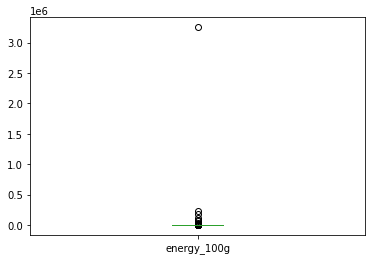

In [ ]:
#values for energy appear to be mixing kj and kcal resulting in some extremes
#Unfortunately fats and ethanol have the greatest amount of food energy per gram, 37 and 29 kilojoules per gram 3700
#While suboptimal, I will reduce all vals over 3000 to 3000
#Then I will apply the formula of conversion to all vals between 1000 and 3000
#This will affect the truth of results, but to continue working on the data some transformation is necessary
#Values for other /100g do not seem to present the same difficulty, so they will be left alone
df['energy_100g'].plot.box()

In [ ]:
df.loc[df['energy_100g'] >= 3000, 'energy_100g'] = 3000

In [ ]:
#quick sample of sum data to convert
df[(df['energy_100g']>1000) & (df['energy_100g']<3000)][['product_name', 'energy_100g']].head(5)

,product_name,energy_100g
1,Banana Chips Sweetened (Whole),2243.0
2,Peanuts,1941.0
3,Organic Salted Nut Mix,2540.0
4,Organic Polenta,1552.0
5,Breadshop Honey Gone Nuts Granola,1933.0


In [ ]:
#clearly mixing kj and kcal conversion is 1 to 0.239006
mask = (df['energy_100g']>1000) & (df['energy_100g']<3000)
df[mask]['energy_100g'].apply(lambda x: x*0.239006)

1         536.090458
2         463.910646
3         607.075240
4         370.937312
5         461.998598
             ...    
320730    325.048160
320732    332.935358
320738    332.935358
320742    353.011862
320771    500.000552
Name: energy_100g, Length: 108188, dtype: float64

In [ ]:
#some values below zero affecting results
mask = df['sugars_100g'].isna()==False
df.loc[df['sugars_100g'] < 0, 'sugars_100g'] = 0
df['sugar_to_energy'] = df['sugars_100g']/df['energy_100g']%100


mask = df['proteins_100g'].isna()==False
df.loc[df['proteins_100g'] < 0, 'proteins_100g'] = 0
df['protein_to_energy'] = df['proteins_100g']/df['energy_100g']%100

In [ ]:
cols_to_drop = ['code', 'url', 'last_modified_datetime', 'ingredients_text', 'additives_n', 'additives',
'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n','states_fr','pnns_groups_2', 'pnns_groups_1']

df = df.drop(cols_to_drop, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182343 entries, 1 to 320771
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   product_name             180676 non-null  object 
 1   brands                   179096 non-null  object 
 2   countries_fr             182306 non-null  object 
 3   nutrition_grade_fr       158644 non-null  object 
 4   energy_100g              181251 non-null  float64
 5   fat_100g                 181060 non-null  float64
 6   saturated-fat_100g       164712 non-null  float64
 7   carbohydrates_100g       181046 non-null  float64
 8   sugars_100g              171392 non-null  float64
 9   fiber_100g               152064 non-null  float64
 10  proteins_100g            180574 non-null  float64
 11  salt_100g                179711 non-null  float64
 12  sodium_100g              179679 non-null  float64
 13  nutrition-score-fr_100g  158644 non-null  float64
 14  nutr

In [ ]:
df['nutrition_grade_fr'] = df['nutrition_grade_fr'].astype('category')
df['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g'].astype('category')
df['product_name'] = df['product_name'].astype('category')

In [ ]:
#classification algo
df_for_ml = df.select_dtypes(['float64', 'category']).drop(['nutrition-score-uk_100g'], axis=1)
df_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182343 entries, 1 to 320771
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   product_name             180676 non-null  category
 1   nutrition_grade_fr       158644 non-null  category
 2   energy_100g              181251 non-null  float64 
 3   fat_100g                 181060 non-null  float64 
 4   saturated-fat_100g       164712 non-null  float64 
 5   carbohydrates_100g       181046 non-null  float64 
 6   sugars_100g              171392 non-null  float64 
 7   fiber_100g               152064 non-null  float64 
 8   proteins_100g            180574 non-null  float64 
 9   salt_100g                179711 non-null  float64 
 10  sodium_100g              179679 non-null  float64 
 11  nutrition-score-fr_100g  158644 non-null  category
 12  serving_size_val         182329 non-null  float64 
 13  unique_ingred_count      177770 non-null  fl

In [ ]:
df_for_ml = df_for_ml.dropna()
df_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142004 entries, 1 to 320742
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   product_name             142004 non-null  category
 1   nutrition_grade_fr       142004 non-null  int64   
 2   energy_100g              142004 non-null  float64 
 3   fat_100g                 142004 non-null  float64 
 4   saturated-fat_100g       142004 non-null  float64 
 5   carbohydrates_100g       142004 non-null  float64 
 6   sugars_100g              142004 non-null  float64 
 7   fiber_100g               142004 non-null  float64 
 8   proteins_100g            142004 non-null  float64 
 9   salt_100g                142004 non-null  float64 
 10  sodium_100g              142004 non-null  float64 
 11  nutrition-score-fr_100g  142004 non-null  category
 12  serving_size_val         142004 non-null  float64 
 13  unique_ingred_count      142004 non-null  fl

In [ ]:
df['nutrition_grade_fr'].value_counts()

d    46925
c    32974
e    31879
a    26347
b    20519
Name: nutrition_grade_fr, dtype: int64

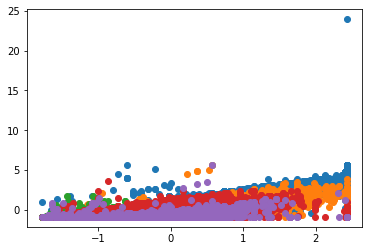

In [ ]:
# mini-batch k-means clustering


scaler = StandardScaler()

# define dataset
X = df_for_ml.drop(['nutrition_grade_fr', 'nutrition-score-fr_100g', 'product_name'], axis=1).values
X = scaler.fit_transform(X)

model = MiniBatchKMeans(n_clusters=5)
model.fit(X)

yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

df_for_ml['kmeans'] = yhat

In [ ]:
df_for_ml.groupby(['kmeans', 'nutrition_grade_fr'])['nutrition_grade_fr'].count()
km_gb = df_for_ml.groupby(['kmeans', 'nutrition-score-fr_100g'])['nutrition-score-fr_100g'].count()
#nutrition-score-fr_100g

km_gb.unstack()

nutrition-score-fr_100g,-15.0,-13.0,-12.0,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,40.0
kmeans,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,4,12,26,44,25,46,98,475,51,61,72,63,103,243,266,505,767,771,812,1003,1043,1038,971,1034,1067,969,1121,1846,2244,870,888,1146,494,312,166,54,4,9,3,1,0,0,1,0,2,1,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,3,2,0,4,17,73,178,254,412,520,576,819,1018,1293,1527,1614,1935,2269,2178,2079,2286,1609,1130,984,744,282,192,142,47,43,90,16,26,6,0,0,0
2,1,16,22,41,70,161,244,351,774,1232,2211,2652,2845,3709,4058,4391,3795,2913,2116,1826,1093,690,495,417,597,1133,1047,629,419,331,301,137,46,16,12,4,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,10,10,4,37,190,321,3040,1521,881,1144,1493,1814,2205,1695,1488,1212,916,544,1560,1704,2182,2604,2688,2660,2554,2193,2173,1602,1313,993,755,512,403,253,118,78,36,10,4,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,1,1,1,3,4,12,19,34,53,90,39,144,195,553,877,322,520,623,1279,2842,824,532,397,349,362,266,199,133,177,218,51,21,11,7,3,7,3,1,0,0,0,0,0,0,0


In [ ]:
abs(df_for_ml.corr())['kmeans'].nlargest(5)

kmeans                1.000000
fat_100g              0.645748
saturated-fat_100g    0.586889
carbohydrates_100g    0.392835
proteins_100g         0.332813
Name: kmeans, dtype: float64

In [ ]:
LE = LabelEncoder()
df_for_ml['nutrition_grade_fr'] = LE.fit_transform(df_for_ml['nutrition_grade_fr'])

In [ ]:
# define dataset
X = df_for_ml.drop(['nutrition_grade_fr', 'nutrition-score-fr_100g', 'product_name', 'kmeans'], axis=1).values
X = scaler.fit_transform(X)

y = df_for_ml['nutrition_grade_fr']
y = pd.get_dummies(y).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
strategy = tf.distribute.MirroredStrategy()
# strategy = tf.distribute.experimental.CentralStorageStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
with strategy.scope():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(18,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CP

In [ ]:
print("Evaluate output:", model.evaluate(X_test, y_test))

1332/1332 [==============================] - 3s 2ms/step - loss: 0.0803 - accuracy: 0.9173
Evaluate output: [0.08026184886693954, 0.9172808527946472]


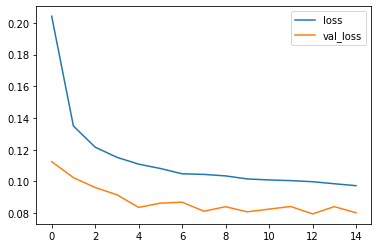

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)

In [ ]:
confusion_matrix(y_test.argmax(axis=1), y_pred)

array([[ 6793,   698,    28,     0,     0],
       [  247,  4601,   630,     3,     0],
       [    2,   279,  8151,   311,     3],
       [    1,     1,   646, 11267,   486],
       [    2,     4,     1,   248,  8200]])